In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

np.random.seed(9630)
tf.random.set_seed(9630)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

11501568/11490434 [==============================] - 0s 0us/step


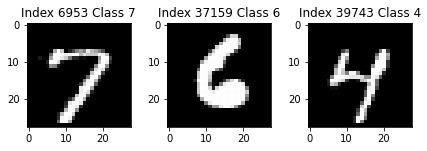

In [ ]:
# Load MNIST or FMNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() 
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() 
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [ ]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [ ]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [ ]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))


tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [ ]:
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = tf.nn.dropout(h1, rate = dropout_p, seed = 9630)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = tf.nn.dropout(h2, rate = dropout_p, seed = 9630)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = tf.nn.dropout(h3, rate = dropout_p, seed = 9630)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 

# SGD

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20
dropout_p = 0.0

seeds = [9630]
# seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, opti)

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

print('\nTotal time take (in seconds): {:.2f}'.format(time.time() - time_start_total))
print('Test Accuracy', test_acc_total)
plt_x = [1,2,3,4,5,6,7,8,9,10]
plt.ylim(0.7, 1.0)
plt.plot(plt_x, test_acc_total, 'ro-')
plt.show()

# RMSprop

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20
dropout_p = 0.0

seeds = [9630]
# seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
opti = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, opti)

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

print('\nTotal time take (in seconds): {:.2f}'.format(time.time() - time_start_total))
print('Test Accuracy', test_acc_total)
plt_x = [1,2,3,4,5,6,7,8,9,10]
plt.ylim(0.7, 1.0)
plt.plot(plt_x, test_acc_total, 'ro-')
plt.show()

# Adam

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20
dropout_p = 0.0

seeds = [9630]
# seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
opti = tf.keras.optimizers.Adam(learning_rate = 1e-4)
time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, opti)

    preds = mlp_on_cpu.forward(X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

print('\nTotal time take (in seconds): {:.2f}'.format(time.time() - time_start_total))
print('Test Accuracy', test_acc_total)
plt_x = [1,2,3,4,5,6,7,8,9,10]
plt.ylim(0.7, 1.0)
plt.plot(plt_x, test_acc_total, 'ro-')
plt.show()